## Common Test I. Multi-Class Classification 

`Task`: Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

`Dataset`: [dataset.zip](https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view) - Google Drive

`Dataset Description`: The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

`Evaluation Metrics`: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

## Downloading and unzipping Data

Avoid this if you have downloaded data locally.

In [1]:
# Downloading Task 1 data
! gdown "1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A&confirm=t
To: /content/dataset.zip
100% 1.13G/1.13G [00:08<00:00, 129MB/s]


Here we are extracting the given data in a folder name `test_1`.

In [2]:
from zipfile import ZipFile
from pathlib import Path

OUT_DIR = Path('test_1')

if not OUT_DIR.exists():
    with ZipFile('dataset.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)

Analysing the dataset, we have data already splitted into tran and validations sets. We have data devided into 3  classes. Those are `no`, `sphere` and `vort`.

## Installing and importing libraries

In [15]:
! pip install timm -q

In [1]:

import timm
import json
import random
import numpy as np
from glob import glob
from  pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Pytorch Related imports
import torch
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


## Vizualizing Images

Here we define a function `show_img`, to display image from any of the three classes.

In [16]:

def show_imgs(cls, rows= 3 , cols = 5):
    """
    Display Images of a specific class
    """
    n_imgs = cols * rows

    paths = random.sample(glob(f"test_1/dataset/train/{cls}/*.npy"), k = n_imgs)

    fig, axs = plt.subplots(rows, cols, figsize=(15, 9))
    axs = axs.flatten()
    for path, ax in zip(paths, axs):
        img = np.load(path)[0]
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'Class - {cls}', fontsize=30)
    plt.tight_layout()

    plt.savefig(Path('assets')/f"Class - {cls}.png", dpi = 600)
    plt.show()



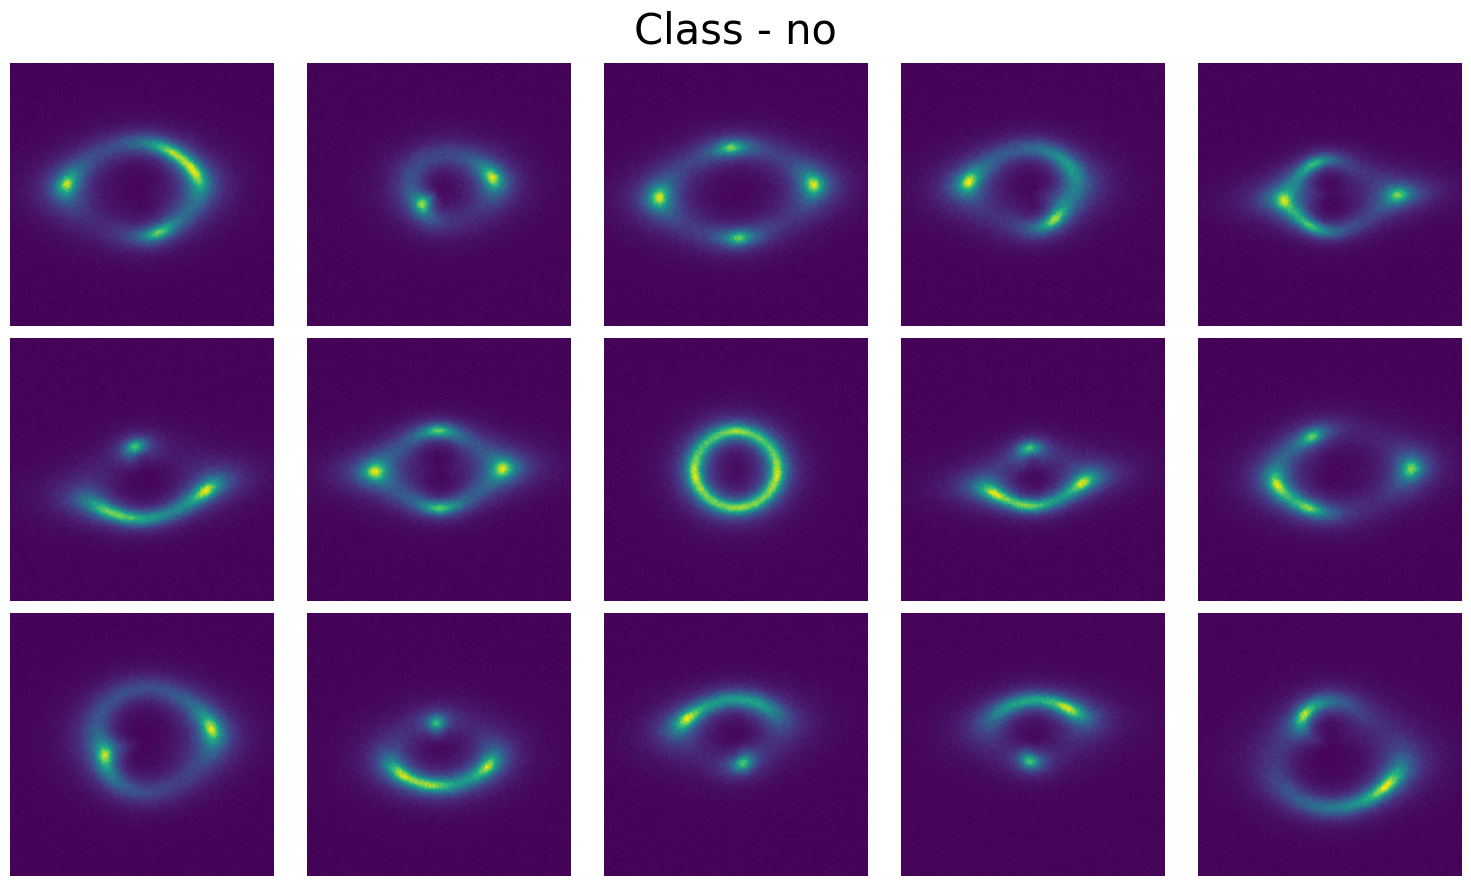

In [17]:
# An example image (from class no)
show_imgs(cls = "no")

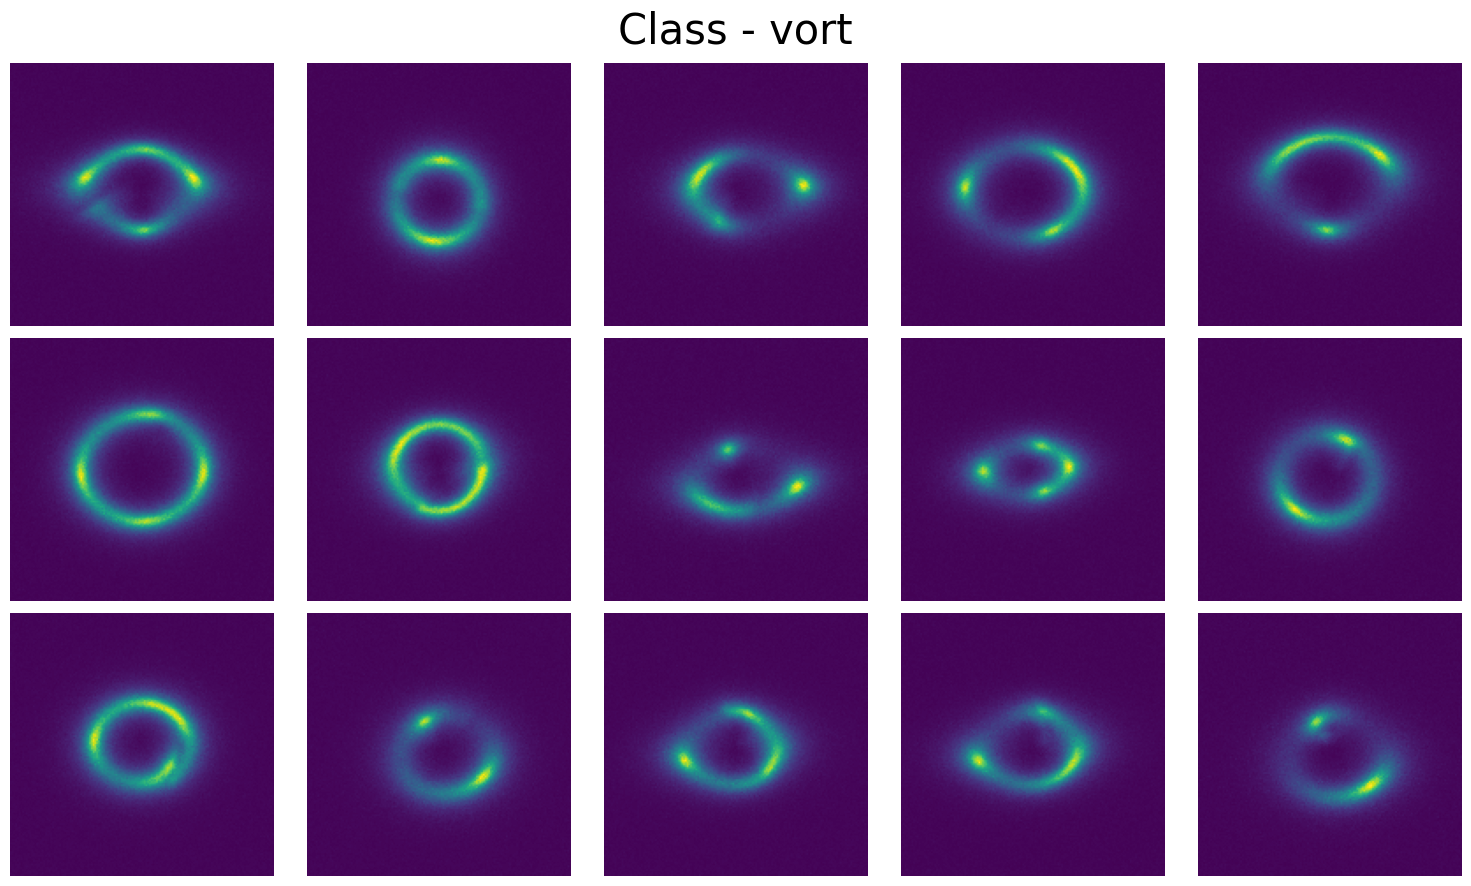

In [18]:
# An example image (from class vort)
show_imgs(cls = "vort")

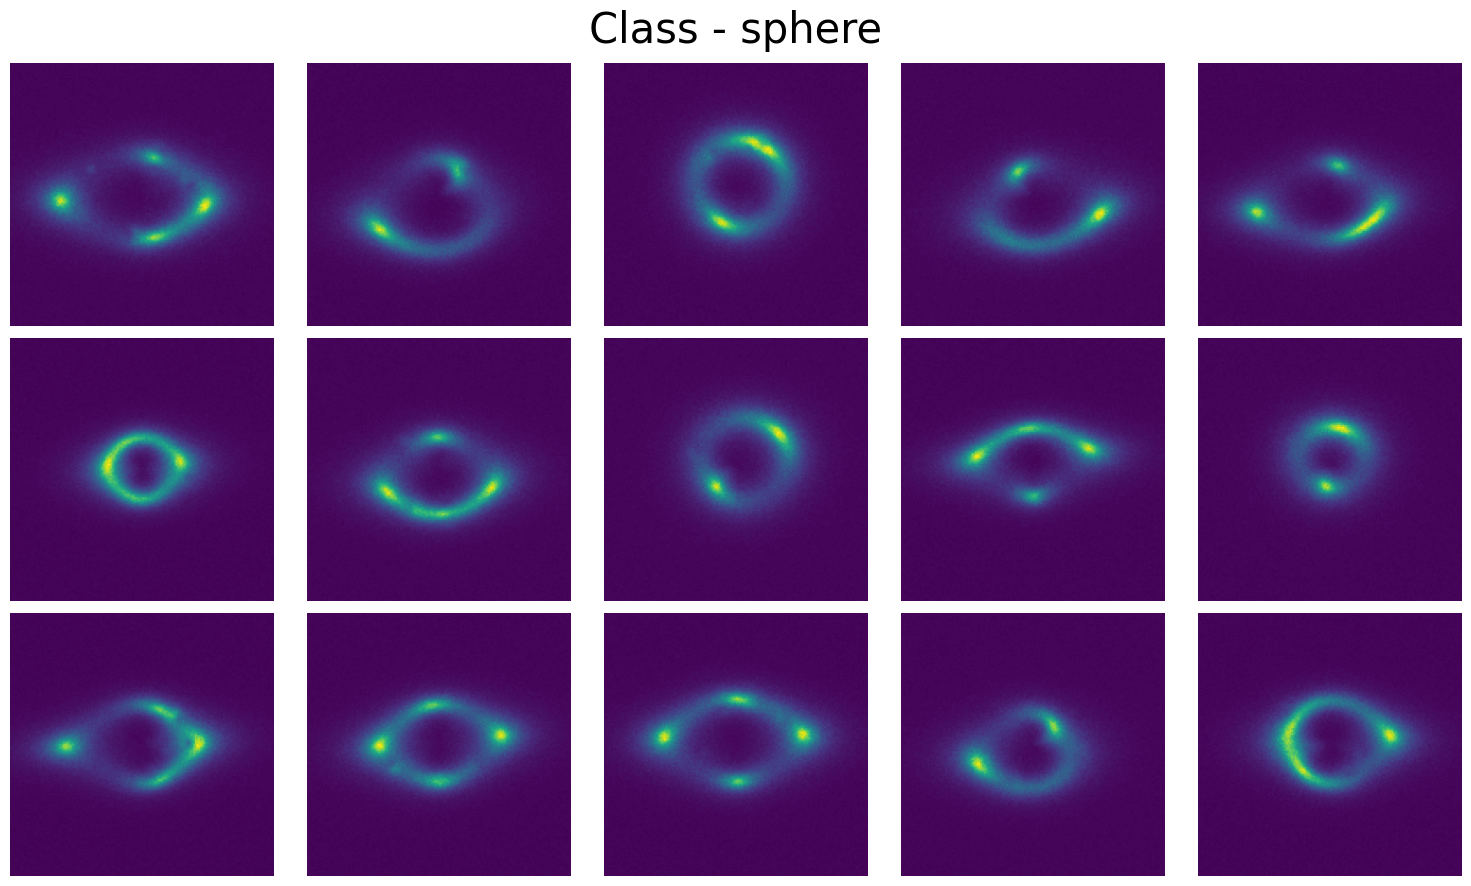

In [19]:
# An example image (from class sphere)
show_imgs(cls = "sphere")

##  Preparing Dataset and Dataloader

In [22]:
# Define a dictionary of image transforms for training and validation datasets.
image_transforms = {
    # For the "train" dataset, apply the following transforms in sequence:
    "train": transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor.
        transforms.CenterCrop(100),  # Crop the center of the image.
        transforms.Resize(224),  # Resize the image to 224x224 pixels.
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with probability 0.5.
        transforms.RandomVerticalFlip(p=0.5)  # Randomly flip the image horizontally with probability 0.5.
    ]),

    # For the "val" dataset, apply the following transforms in sequence:
    "val": transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor.
        transforms.CenterCrop(100),  # Crop the center of the image.
        transforms.Resize(224)  # Resize the image to 224x224 pixels.
    ])
}

In [23]:

# Define a lambda function to check if a file has a '.npy' extension.
valid_checker = lambda x: x.endswith('.npy')

# Define a lambda function to load a .npy file as a 3-channel image.
npy_loader = lambda x: np.array([np.load(x)[0]]*3).transpose(1, 2, 0).astype('float32')

# Create a training dataset by loading images from the "train" directory.
train_dset = datasets.ImageFolder(root = "test_1/dataset/train",
                                   transform = image_transforms["train"],
                                   is_valid_file = valid_checker,
                                   loader = npy_loader
                                  )

# Create a validation dataset by loading images from the "val" directory.
val_dset = datasets.ImageFolder(root = "test_1/dataset/val",
                                   transform = image_transforms["val"],
                                   is_valid_file = valid_checker,
                                   loader = npy_loader
                                  )

In [24]:
# Testing the dataloader
train_dset.__getitem__(34)[0].shape, train_dset.__getitem__(34)[1]

(torch.Size([3, 224, 224]), 0)

In [25]:
# Create a dictionary mapping class indices to class names for the training dataset.
idx2class = {v: k for k, v in train_dset.class_to_idx.items()}
# Print the resulting dictionary.
print(idx2class)


{0: 'no', 1: 'sphere', 2: 'vort'}


## Preparing Model

First we write a small pytorch model `LensModel`, but we don't get satisfactory performance out of it (better results with pretrained models).

In [26]:


class LensModel(nn.Module):
    """
    A PyTorch neural network model for classifying images based on lens type.

    Args:
        num_classes (int): The number of classes to classify.
        in_channels (int, optional): The number of input channels. Defaults to 1.

    Attributes:
        conv1 (nn.Conv2d): The first convolutional layer.
        bn1 (nn.BatchNorm2d): The first batch normalization layer.
        relu1 (nn.ReLU): The first ReLU activation layer.
        conv2 (nn.Conv2d): The second convolutional layer.
        bn2 (nn.BatchNorm2d): The second batch normalization layer.
        relu2 (nn.ReLU): The second ReLU activation layer.
        pool (nn.AdaptiveAvgPool2d): The adaptive average pooling layer.
        fc (nn.Linear): The fully connected output layer.
        softmax (nn.Softmax): The softmax activation layer.

    """
    def __init__(self, num_classes, in_channels=1):
        super(LensModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=32, out_features=num_classes)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        """
        Compute forward pass through the neural network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

In [27]:
# Testing the model
model = LensModel(num_classes = 3, in_channels=3)
model(torch.zeros((5, 3, 150, 150)))

tensor([[0.3151, 0.3672, 0.3177],
        [0.3151, 0.3672, 0.3177],
        [0.3151, 0.3672, 0.3177],
        [0.3151, 0.3672, 0.3177],
        [0.3151, 0.3672, 0.3177]], grad_fn=<SoftmaxBackward0>)

## Trainer class 

This `Trainer` class will manage the whole training and validation pipeline.

In [29]:


class Trainer:
    
    # Constructor function of the Trainer class
    def __init__(self, model_name, model, train_dset, val_dset, loss_type, optim_type, batch_size, load = False):
        
        # Sets the device to GPU if it is available, otherwise uses CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Stores the given model_name
        self.model_name = model_name

        # Creates a path object with the given model_name
        self.model_dir = Path(model_name)

        # Creates a directory with the given model_name if it does not exist
        if load:
            self.model_dir.mkdir(exist_ok=True)
        else:
            self.model_dir.mkdir()

        # Assigns the given model to the device
        self.model = model.to(self.device)

        # Stores the given training dataset
        self.train_dset = train_dset

        # Stores the given validation dataset
        self.val_dset = val_dset

        # Creates train and validation  dataloaders  from  provided  datasets.
        self.train_loader = self.get_dataloader(dl_type = "train" , batch_size = batch_size)
        self.val_loader = self.get_dataloader(dl_type = "val" , batch_size = batch_size)

        # Creates loss function and optimizer
        self.loss_fn = self.get_loss(loss_type)
        self.optimizer = self.get_optimizer(optim_type)

        # Creates dictionary to log all training informations
        self.info_dict = {}
        self.info_dict["last_epoch"] = -1
        self.info_dict["best_acc"] = 0


    def get_loss(self, loss_type):

        # If loss_type is Cross Entropy, return the CrossEntropyLoss function
        if loss_type == "ce":
            return nn.CrossEntropyLoss(reduction='mean')
        
        # Otherwise, raise a TypeError.
        else:
            raise TypeError("Only Crossentropy type is supported for now") 
    

    def get_optimizer(self, optim_type):

        # If optimizer type is Adam, return Adam optimizer
        if optim_type == "adam":
            return Adam(self.model.parameters(), lr=1e-6)
        
        # If optimizer type is SGD, return SGD optimizer
        elif optim_type == "sgd":
            return SGD(self.model.parameters(), lr=0.1, momentum=0.9)
        
        # Otherwise, raise a TypeError.
        else:
            raise TypeError("This optimizer type is not yet supported") 

    
    def get_dataloader(self, dl_type , batch_size):
        
        # If the data loader type is 'train', return a DataLoader with the training dataset
        if dl_type == "train":
            return DataLoader(self.train_dset, batch_size=batch_size, shuffle=True)
        
        # If the data loader type is 'val', return a DataLoader with the validation dataset
        elif dl_type == "val":
            return DataLoader(self.val_dset, batch_size=batch_size, shuffle=False)
        
        # Otherwise, raise a TypeError.
        else:
            raise TypeError("Only support train and validation dataloader currently.")


    # define a method for training one epoch
    def train_one_epoch(self):
        
        # set the model to train mode
        self.model.train()
        
        # initialize variables for tracking training loss and accuracy
        train_loss = 0.0
        correct = 0
        total = 0
        
        # iterate over the training loader
        for data, target in tqdm(self.train_loader):
            # move data and target to device
            data, target = data.to(self.device), target.to(self.device)
            
            # zero the optimizer gradients
            self.optimizer.zero_grad()
            
            # get the model output and update weights
            output = self.model(data)
            loss = self.loss_fn(output, target)
            loss.backward()
            self.optimizer.step()
            
            # update training loss and accuracy
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
        # calculate final training loss and accuracy
        train_loss /= len(self.train_loader.dataset)
        train_acc = 100. * correct / total
        
        # return the training loss and accuracy
        return train_loss, train_acc
    

    # define a method for validating one epoch
    def val_one_epoch(self):

        # set the model to evaluation mode
        self.model.eval()
        
        # initialize variables for tracking validation loss and accuracy
        val_loss = 0.0
        correct = 0
        total = 0
        
        # iterate over the validation loader
        with torch.no_grad():
            for data, target in tqdm(self.val_loader):
                
                # move data and target to device
                data, target = data.to(self.device), target.to(self.device)
                
                # get the model output and calculate loss
                output = self.model(data)
                loss = self.loss_fn(output, target)
                
                # update validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
                
        # calculate final validation loss and accuracy
        val_loss /= len(self.val_loader.dataset)
        val_acc = 100. * correct / total
        
        # return the validation loss and accuracy
        return val_loss, val_acc
    
    def run_training(self, num_epochs, run_valid = True, patience = 5):
        
        # Set the starting epoch for training
        self.start_epoch = self.info_dict["last_epoch"] + 1

        # Initialize empty training loss and accuracy history if not present in info_dict
        if "train_loss_history" not in self.info_dict.keys():
            self.info_dict["train_loss_history"] = []
        if "train_acc_history" not in self.info_dict.keys():
            self.info_dict["train_acc_history"] = []
        
        # Initialize current patience for Early stopping
        current_patience = patience

        # Loop through each epoch and run training for that epoch
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            
            # Run one training epoch
            train_loss, train_acc = self.train_one_epoch()
            
            # Update the info_dict with training loss and accuracy for the current epoch
            self.info_dict["last_epoch"] = epoch
            self.info_dict["train_loss_history"].append(train_loss)
            self.info_dict["train_acc_history"].append(train_acc)
            
            # Print training loss and accuracy for the current epoch
            print('Epoch {}/{}: Train Loss: {:.4f} Train Acc: {:.2f}%'.format(epoch+1, num_epochs, train_loss, train_acc))
            
            # Run validation if specified
            if run_valid:

                # Check if current validation is best and update patience accordingly
                isBest  = self.run_validation()
                if isBest:
                    current_patience = patience
                else:
                    current_patience -= 1
                    print(f"Patience reduced to {current_patience}.")
                    
                    # Stop training early if validation doesn't improve for a certain number of epochs
                    if current_patience == 0:
                        print(f"Validation not improving from last {patience} epochs. Stopping early.")
                        break
            
            # Save the model and optimizer parameters after each epoch
            self.save_json()


    def run_validation(self):
        
        # Initialize empty validation loss and accuracy history if not present in info_dict
        if "val_loss_history" not in self.info_dict.keys():
            self.info_dict["val_loss_history"] = []
        if "val_acc_history" not in self.info_dict.keys():
            self.info_dict["val_acc_history"] = []

        # Run one validation epoch
        val_loss, val_acc = self.val_one_epoch()

        # Update the info_dict with validation loss and accuracy for the current epoch
        self.info_dict["val_loss_history"].append(val_loss)
        self.info_dict["val_acc_history"].append(val_acc)
        
        # Print validation loss and accuracy for the current epoch
        print('Validation Loss: {:.4f} Validation Acc: {:.2f}%'.format(val_loss, val_acc))

        # Save the model if validation accuracy improves and update the best accuracy in info_dict
        if val_acc > self.info_dict["best_acc"]:
            print(f"Got improved val accuracy: {val_acc}")
            self.save('best_ckpt.pth')
            self.info_dict["best_acc"] = val_acc

            return True
        
        # Return False if validation accuracy doesn't improve
        return False


    # Define a method to save the info_dict to a JSON file
    def save_json(self, json_path = "model.json"):
        with open(self.model_dir/json_path, 'w') as f:
            json.dump(self.info_dict, f, ensure_ascii=False)

    # Define a method to save the current model state to a checkpoint file
    def save(self, path):
        
        # Save the current epoch, model state dict, and optimizer state dict to a dictionary and
        # save it to a file at the given path in the model_dir directory
        torch.save({
            'epoch': self.info_dict["last_epoch"],
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
            }, self.model_dir/path)
        
        # Save only the model state dict to a file at the given path
        torch.save(self.model.state_dict(), path)

        # Save only the model state dict to a file at the given path
        self.save_json()
        

    # Define a method to load a model from a checkpoint file and its corresponding info_dict from a JSON file
    def load(self, path, json_path = "model.json"):

        # Load the checkpoint file into a dictionary
        ckpt = torch.load(path)

        # Load the epoch number, model state dict and optimizer state dict from the loaded model
        self.info_dict["last_epoch"] = ckpt['epoch']
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load the info_dict from the given JSON file
        if json_path:
            with open(json_path) as json_file:
                self.info_dict = json.load(json_file)
                
    # Define a method to convert class labels to one-hot vectors
    def __to_one_hot_vector(self,num_class, label):
        b = np.zeros((label.shape[0], num_class))
        b[np.arange(label.shape[0]), label] = 1
        return b.astype(int)


    # Define a method for plotting ROC and calculate Area under ROC curve
    def plot_ROC(self):

        # update default plot settings
        plt.rcParams.update(plt.rcParamsDefault)

        # initialize variables
        total = 0
        label_true_arr = []
        label_pred_arr = []
        correct = 0

        # turn off gradients and set model to evaluation mode
        with torch.no_grad():
            self.model.eval()

            # loop through validation data loader
            for i, (x, t) in enumerate(tqdm(self.val_loader)):

                # move data and labels to device
                x = x.to(self.device)
                t = t.to(self.device)

                # forward pass and get model output
                y = self.model(x)

                # append model output to predicted labels array
                label_pred_arr.append(y.cpu().numpy())

                # calculate total and correct predictions
                _, prediction = torch.max(y.data, 1)
                total += t.shape[0]
                correct += (prediction == t).sum().item()

                # convert labels to one-hot encoded arrays and append to true labels array
                one_hot_t = self.__to_one_hot_vector(3,t.cpu().numpy())
                label_true_arr.append(one_hot_t)

        # convert true and predicted labels arrays to numpy arrays
        y_test = []
        for i in label_true_arr:
            for j in i:
                y_test.append(list(j))
        y_test = np.array(y_test)

        y_score = []
        for i in label_pred_arr:
            for j in i:
                y_score.append(list(j))
        y_score = np.array(y_score)

        # initialize dictionaries for false positive rate, true positive rate, and ROC area under curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # get number of classes
        n_classes = len(self.val_dset.class_to_idx)

        # loop through classes to compute ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # create dictionary mapping index to class name
        inv_map = {v: k for k, v in self.val_dset.class_to_idx.items()}

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # plot ROC curve
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                label='micro-average ROC curve (area = {0:0.4f})'
                    ''.format(roc_auc["micro"]))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                        ''.format(roc_auc[i]))

        # plot chance line
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_name} ROC')
        plt.legend(loc="lower right")
        plt.savefig(self.model_dir/f"{self.model_name} - ROC.png", dpi = 600)

        plt.show()

    def plot_loss(self):
        plt.plot(self.info_dict['train_loss_history'] , label='Train Loss')
        plt.plot(self.info_dict['val_loss_history'] , label='Validation Loss')
        plt.title(f'{self.model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss value')
        plt.legend(loc="upper right")
        plt.savefig(self.model_dir/f"{self.model_name} - loss.png", dpi = 600)

        plt.show()

    def plot_accuracy(self):
        plt.plot(self.info_dict['train_acc_history'] , label='Train Loss')
        plt.plot(self.info_dict['val_acc_history'] , label='Validation Loss')
        plt.title(f'{self.model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy value')
        plt.legend(loc="lower right")
        plt.savefig(self.model_dir/f"{self.model_name} - Accuracy.png", dpi = 600)
        plt.show()

## Training

In [16]:
# Model for usage
model_name = 'vit_tiny_patch16_224_in21k'
timm_resnet = timm.create_model(model_name, pretrained = True, num_classes = 3)

# Creating Trainer  object
trainer = Trainer(model_name,
                  model = timm_resnet, 
                  train_dset=train_dset,
                  val_dset= val_dset,
                  loss_type="ce",
                  optim_type="adam",
                  batch_size = 64,
                  )

In [ ]:
trainer.run_training(150)

## Evaluation

### If you are here to evaluate already trained models, this  section is for you.

`Step 1`: Download the model weights (and optionally model.json file) from links in README.md

`Step 2`: Run this notebook upto defining  the Trainer class.

`Step 3`: Replace the `model_name`, weight and Json paths in the next cell.

Now, run the next cells, and  it will create the `ROC.png` in corresponding model folder in nootbook directory.

In [45]:

model_name = 'convit_tiny'
json_path = r"convit_tiny\model.json"
weight_path =r"convit_tiny\best_ckpt.pth"

# Creating model for usage
timm_resnet = timm.create_model(model_name, num_classes = 3)

# Creating Trainer  object
trainer = Trainer(model_name,
                  model = timm_resnet, 
                  train_dset=train_dset,
                  val_dset= val_dset,
                  loss_type="ce",
                  optim_type="adam",
                  batch_size = 64,
                  load =True
                  )

trainer.load(path=weight_path, json_path=json_path)

  0%|          | 0/118 [00:00<?, ?it/s]

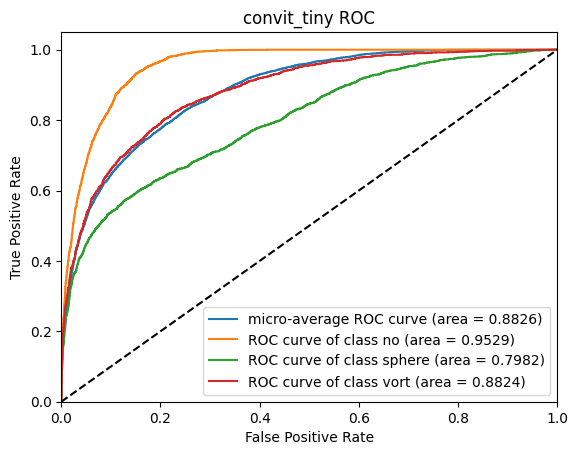

In [46]:
trainer.plot_ROC()

Optionally, we can also plot `Loss` and `Accuracy` curves if we have the `model.json`  file.



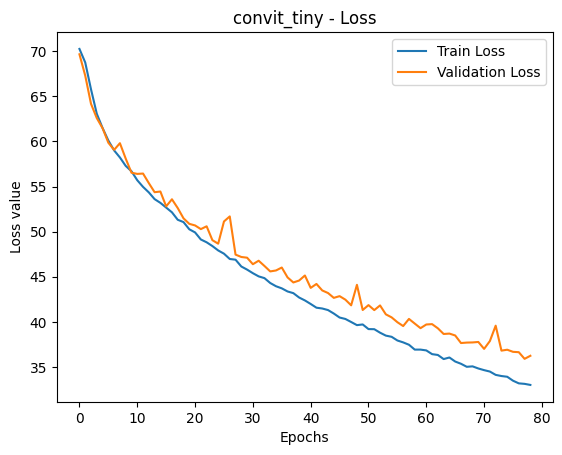

In [47]:
trainer.plot_loss()

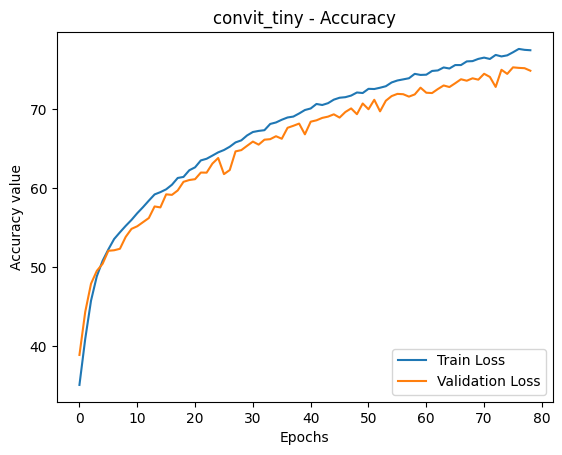

In [48]:
trainer.plot_accuracy()